# Depth estimation with DepthAnythingV2 and OpenVINO

[Depth Anything V2](https://depth-anything-v2.github.io/) is a solution for robust relative depth estimation. Without pursuing fancy techniques, this project aim to reveal crucial findings to pave the way towards building a powerful monocular depth estimation model. This model is an improvement of the [Depth Anything V1](https://depth-anything.github.io/). Notably, compared with V1, this version produces much finer and more robust depth predictions through three key practices: replacing all labeled real images with synthetic images, scaling up the capacity of our teacher model and teaching student models via the bridge of large-scale pseudo-labeled real images.


The pipeline of training of Depth Anything V2 is shown below. It consists of three steps: train a reliable teacher model purely on high-quality synthetic image; produce precise pseudo depth on large-scale unlabeled real images; train final student models on pseudo-labeled real images for robust generalization.

![image.png](https://depth-anything-v2.github.io/static/images/pipeline.png)

More details about model can be found in [project web page](https://depth-anything-v2.github.io/), [paper](https://arxiv.org/abs/2406.09414) and official [repository](https://github.com/DepthAnything/Depth-Anything-V2)

In this tutorial we will explore how to convert and run DepthAnythingV2 using OpenVINO. An additional part demonstrates how to run quantization with [NNCF](https://github.com/openvinotoolkit/nncf/) to speed up the model.




#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Load and run PyTorch model](#Load-and-run-PyTorch-model)
    - [Prepare input data](#Prepare-input-data)
    - [Run model inference](#Run-model-inference)
- [Convert Model to OpenVINO IR format](#Convert-Model-to-OpenVINO-IR-format)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)
    - [Select inference device](#Select-inference-device)
    - [Run inference on image](#Run-inference-on-image)
    - [Run inference on video](#Run-inference-on-video)
- [Quantization](#Quantization)
    - [Prepare calibration dataset](#Prepare-calibration-dataset)
    - [Run quantization](#Run-quantization)
        - [Compare model file size](#Compare-model-file-size)
    - [Compare inference time of the FP16 and INT8 models](#Compare-inference-time-of-the-FP16-and-INT8-models)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/depth-anything/depth-anything-v2.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from pathlib import Path


repo_dir = Path("Depth-Anything-V2")

if not repo_dir.exists():
    !git clone https://huggingface.co/spaces/depth-anything/Depth-Anything-V2
%cd Depth-Anything-V2

In [ ]:
import platform

%pip install -q "openvino>=2024.2.0" "datasets>=2.14.6" "nncf>=2.11.0" "tqdm" "matplotlib>=3.4"
%pip install -q "typing-extensions>=4.9.0" eval-type-backport "gradio>=4.19"
%pip install -q -r requirements.txt --extra-index-url https://download.pytorch.org/whl/cpu

if platform.python_version_tuple()[1] in ["8", "9"]:
    %pip install -q "gradio-imageslider<=0.0.17" "typing-extensions>=4.9.0"

## Load and run PyTorch model
[back to top ⬆️](#Table-of-contents:)

To be able run PyTorch model on CPU, we should disable xformers attention optimizations first.

In [3]:
attention_file_path = Path("./depth_anything_v2/dinov2_layers/attention.py")
orig_attention_path = attention_file_path.parent / ("orig_" + attention_file_path.name)

if not orig_attention_path.exists():
    attention_file_path.rename(orig_attention_path)

    with orig_attention_path.open("r") as f:
        data = f.read()
        data = data.replace("XFORMERS_AVAILABLE = True", "XFORMERS_AVAILABLE = False")
        with attention_file_path.open("w") as out_f:
            out_f.write(data)

### Prepare input data
[back to top ⬆️](#Table-of-contents:)

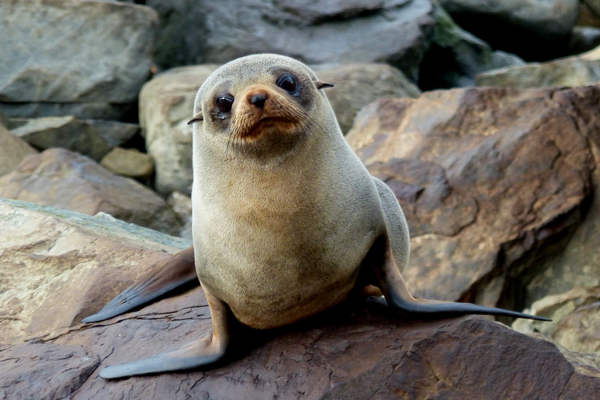

In [4]:
from PIL import Image

import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)
from notebook_utils import download_file, device_widget, quantization_widget

download_file(
    "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/3f779fc1-c1b2-4dec-915a-64dae510a2bb",
    "furseal.png",
)

Image.open("furseal.png").resize((600, 400))

### Run model inference
[back to top ⬆️](#Table-of-contents:)

`DepthAnythingV2.from_pretrained` method creates PyTorch model class instance and load model weights. There are 3 available models in repository depends on VIT encoder size:
* Depth-Anything-V2-Small (24.8M)
* Depth-Anything-V2-Base (97.5M)
* Depth-Anything-V2-Large (335.3M)

We will use `Depth-Anything-V2-Small`, but the same steps for running model and converting to OpenVINO are applicable for other models from DepthAnythingV2 family.

In [ ]:
from huggingface_hub import hf_hub_download

encoder = "vits"
model_type = "Small"
model_id = f"depth_anything_v2_{encoder}"

model_path = hf_hub_download(repo_id=f"depth-anything/Depth-Anything-V2-{model_type}", filename=f"{model_id}.pth", repo_type="model")

Preprocessed image passed to model forward and model returns depth map in format `B` x `H` x `W`, where `B` is input batch size, `H` is preprocessed image height, `W` is preprocessed image width. 

In [ ]:
import cv2
import torch
import torch.nn.functional as F

from depth_anything_v2.dpt import DepthAnythingV2

model = DepthAnythingV2(encoder=encoder, features=64, out_channels=[48, 96, 192, 384])
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

raw_img = cv2.imread("furseal.png")
image, (h, w) = model.image2tensor(raw_img)
image = image.to("cpu").to(torch.float32)

with torch.no_grad():
    depth = model.forward(image)

depth = F.interpolate(depth[:, None], (h, w), mode="bilinear", align_corners=True)[0, 0]

output = depth.cpu().numpy()

In [7]:
from matplotlib import pyplot as plt
import numpy as np
import cv2


def get_depth_map(output, w, h):
    depth = cv2.resize(output, (w, h))

    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    depth = depth.astype(np.uint8)

    depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)

    return depth

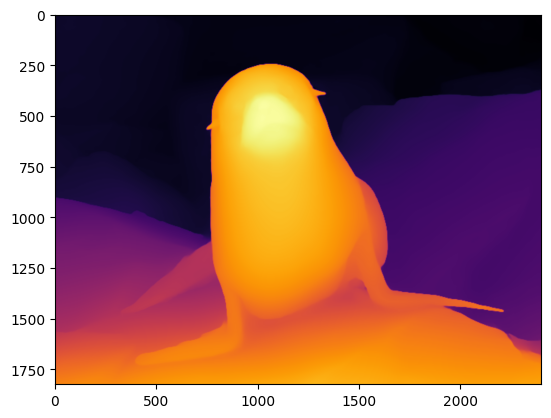

In [10]:
h, w = raw_img.shape[:-1]
res_depth = get_depth_map(output, w, h)
plt.imshow(res_depth[:, :, ::-1])

## Convert Model to OpenVINO IR format
[back to top ⬆️](#Table-of-contents:)

OpenVINO supports PyTorch models via conversion to OpenVINO Intermediate Representation (IR). OpenVINO model conversion API should be used for these purposes. `ov.convert_model` function accepts original PyTorch model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. Converted model can be used for saving on disk using `ov.save_model` function or directly loading on device using `core.complie_model`.

In [12]:
import openvino as ov

OV_DEPTH_ANYTHING_PATH = Path(f"{model_id}.xml")

if not OV_DEPTH_ANYTHING_PATH.exists():
    ov_model = ov.convert_model(model, example_input=torch.rand(1, 3, 518, 518), input=[1, 3, 518, 518])
    ov.save_model(ov_model, OV_DEPTH_ANYTHING_PATH)

## Run OpenVINO model inference
[back to top ⬆️](#Table-of-contents:)

Now, we are ready to run OpenVINO model

### Select inference device
[back to top ⬆️](#Table-of-contents:)

For starting work, please select inference device from dropdown list.

In [13]:
device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [14]:
core = ov.Core()

compiled_model = core.compile_model(OV_DEPTH_ANYTHING_PATH, device.value)

### Run inference on image
[back to top ⬆️](#Table-of-contents:)

For simplicity of usage, model authors provide helper functions for preprocessing input image. The main conditions are that image size should be divisible on 14 (size of vit patch) and normalized in [0, 1] range.

In [15]:
from depth_anything_v2.util.transform import Resize, NormalizeImage, PrepareForNet
from torchvision.transforms import Compose

transform = Compose(
    [
        Resize(
            width=518,
            height=518,
            resize_target=False,
            ensure_multiple_of=14,
            resize_method="lower_bound",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet(),
    ]
)

In [16]:
h, w = raw_img.shape[:-1]

image = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB) / 255.0
image = transform({"image": image})["image"]
image = torch.from_numpy(image).unsqueeze(0)

res = compiled_model(image)[0]

In [17]:
depth_color = get_depth_map(res[0], w, h)

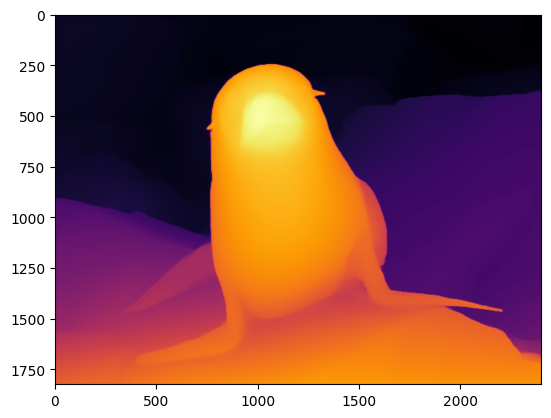

In [18]:
plt.imshow(depth_color[:, :, ::-1])

### Run inference on video
[back to top ⬆️](#Table-of-contents:)

In [19]:
download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4",
    "./Coco Walking in Berkeley.mp4",
)

VIDEO_FILE = "./Coco Walking in Berkeley.mp4"
# Number of seconds of input video to process. Set `NUM_SECONDS` to 0 to process
# the full video.
NUM_SECONDS = 4
# Set `ADVANCE_FRAMES` to 1 to process every frame from the input video
# Set `ADVANCE_FRAMES` to 2 to process every second frame. This reduces
# the time it takes to process the video.
ADVANCE_FRAMES = 2
# Set `SCALE_OUTPUT` to reduce the size of the result video
# If `SCALE_OUTPUT` is 0.5, the width and height of the result video
# will be half the width and height of the input video.
SCALE_OUTPUT = 0.5
# The format to use for video encoding. The 'vp09` is slow,
# but it works on most systems.
# Try the `THEO` encoding if you have FFMPEG installed.
# FOURCC = cv2.VideoWriter_fourcc(*"THEO")
FOURCC = cv2.VideoWriter_fourcc(*"vp09")

# Create Path objects for the input video and the result video.
output_directory = Path("output")
output_directory.mkdir(exist_ok=True)
result_video_path = output_directory / f"{Path(VIDEO_FILE).stem}_depth_anything.mp4"

Coco Walking in Berkeley.mp4:   0%|          | 0.00/877k [00:00<?, ?B/s]

In [20]:
cap = cv2.VideoCapture(str(VIDEO_FILE))
ret, image = cap.read()
if not ret:
    raise ValueError(f"The video at {VIDEO_FILE} cannot be read.")
input_fps = cap.get(cv2.CAP_PROP_FPS)
input_video_frame_height, input_video_frame_width = image.shape[:2]

target_fps = input_fps / ADVANCE_FRAMES
target_frame_height = int(input_video_frame_height * SCALE_OUTPUT)
target_frame_width = int(input_video_frame_width * SCALE_OUTPUT)

cap.release()
print(f"The input video has a frame width of {input_video_frame_width}, " f"frame height of {input_video_frame_height} and runs at {input_fps:.2f} fps")
print(
    "The output video will be scaled with a factor "
    f"{SCALE_OUTPUT}, have width {target_frame_width}, "
    f" height {target_frame_height}, and run at {target_fps:.2f} fps"
)

The input video has a frame width of 640, frame height of 360 and runs at 30.00 fps
The output video will be scaled with a factor 0.5, have width 320,  height 180, and run at 15.00 fps


In [21]:
def normalize_minmax(data):
    """Normalizes the values in `data` between 0 and 1"""
    return (data - data.min()) / (data.max() - data.min())


def convert_result_to_image(result, colormap="viridis"):
    """
    Convert network result of floating point numbers to an RGB image with
    integer values from 0-255 by applying a colormap.

    `result` is expected to be a single network result in 1,H,W shape
    `colormap` is a matplotlib colormap.
    See https://matplotlib.org/stable/tutorials/colors/colormaps.html
    """
    result = result.squeeze(0)
    result = normalize_minmax(result)
    result = result * 255
    result = result.astype(np.uint8)
    result = cv2.applyColorMap(result, cv2.COLORMAP_INFERNO)[:, :, ::-1]
    return result


def to_rgb(image_data) -> np.ndarray:
    """
    Convert image_data from BGR to RGB
    """
    return cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)

In [23]:
import time
from IPython.display import (
    HTML,
    FileLink,
    Pretty,
    ProgressBar,
    Video,
    clear_output,
    display,
)


def process_video(compiled_model, video_file, result_video_path):
    # Initialize variables.
    input_video_frame_nr = 0
    start_time = time.perf_counter()
    total_inference_duration = 0

    # Open the input video
    cap = cv2.VideoCapture(str(video_file))

    # Create a result video.
    out_video = cv2.VideoWriter(
        str(result_video_path),
        FOURCC,
        target_fps,
        (target_frame_width * 2, target_frame_height),
    )

    num_frames = int(NUM_SECONDS * input_fps)
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) if num_frames == 0 else num_frames
    progress_bar = ProgressBar(total=total_frames)
    progress_bar.display()

    try:
        while cap.isOpened():
            ret, image = cap.read()
            if not ret:
                cap.release()
                break

            if input_video_frame_nr >= total_frames:
                break

            h, w = image.shape[:-1]
            input_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0
            input_image = transform({"image": input_image})["image"]
            # Reshape the image to network input shape NCHW.
            input_image = np.expand_dims(input_image, 0)

            # Do inference.
            inference_start_time = time.perf_counter()
            result = compiled_model(input_image)[0]
            inference_stop_time = time.perf_counter()
            inference_duration = inference_stop_time - inference_start_time
            total_inference_duration += inference_duration

            if input_video_frame_nr % (10 * ADVANCE_FRAMES) == 0:
                clear_output(wait=True)
                progress_bar.display()
                # input_video_frame_nr // ADVANCE_FRAMES gives the number of
                # Frames that have been processed by the network.
                display(
                    Pretty(
                        f"Processed frame {input_video_frame_nr // ADVANCE_FRAMES}"
                        f"/{total_frames // ADVANCE_FRAMES}. "
                        f"Inference time per frame: {inference_duration:.2f} seconds "
                        f"({1/inference_duration:.2f} FPS)"
                    )
                )

            # Transform the network result to a RGB image.
            result_frame = to_rgb(convert_result_to_image(result))
            # Resize the image and the result to a target frame shape.
            result_frame = cv2.resize(result_frame, (target_frame_width, target_frame_height))
            image = cv2.resize(image, (target_frame_width, target_frame_height))
            # Put the image and the result side by side.
            stacked_frame = np.hstack((image, result_frame))
            # Save a frame to the video.
            out_video.write(stacked_frame)

            input_video_frame_nr = input_video_frame_nr + ADVANCE_FRAMES
            cap.set(1, input_video_frame_nr)

            progress_bar.progress = input_video_frame_nr
            progress_bar.update()

    except KeyboardInterrupt:
        print("Processing interrupted.")
    finally:
        clear_output()
        processed_frames = num_frames // ADVANCE_FRAMES
        out_video.release()
        cap.release()
        end_time = time.perf_counter()
        duration = end_time - start_time

        print(
            f"Processed {processed_frames} frames in {duration:.2f} seconds. "
            f"Total FPS (including video processing): {processed_frames/duration:.2f}."
            f"Inference FPS: {processed_frames/total_inference_duration:.2f} "
        )
        print(f"Video saved to '{str(result_video_path)}'.")
    return stacked_frame

In [24]:
stacked_frame = process_video(compiled_model, VIDEO_FILE, result_video_path)

Processed 60 frames in 11.85 seconds. Total FPS (including video processing): 5.06.Inference FPS: 12.58 
Video saved to 'output/Coco Walking in Berkeley_depth_anything.mp4'.


In [25]:
def display_video(stacked_frame):
    video = Video(result_video_path, width=800, embed=True)
    if not result_video_path.exists():
        plt.imshow(stacked_frame)
        raise ValueError("OpenCV was unable to write the video file. Showing one video frame.")
    else:
        print(f"Showing video saved at\n{result_video_path.resolve()}")
        print("If you cannot see the video in your browser, please click on the " "following link to download the video ")
        video_link = FileLink(result_video_path)
        video_link.html_link_str = "<a href='%s' download>%s</a>"
        display(HTML(video_link._repr_html_()))
        display(video)

In [26]:
display_video(stacked_frame)

Showing video saved at
/home/labuser/work/notebook/openvino_notebooks/notebooks/depth-anything/Depth-Anything-V2/output/Coco Walking in Berkeley_depth_anything.mp4
If you cannot see the video in your browser, please click on the following link to download the video 


## Quantization
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

The optimization process contains the following steps:

1. Create a calibration dataset for quantization.
2. Run `nncf.quantize()` to obtain quantized model.
3. Save the `INT8` model using `openvino.save_model()` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [27]:
to_quantize = quantization_widget()

to_quantize

Checkbox(value=True, description='Quantization')

In [28]:
# Fetch `skip_kernel_extension` module
r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)

OV_DEPTH_ANYTHING_INT8_PATH = Path(f"{model_id}_int8.xml")

%load_ext skip_kernel_extension

### Prepare calibration dataset
[back to top ⬆️](#Table-of-contents:)

We use a portion of [`Nahrawy/VIDIT-Depth-ControlNet`](https://huggingface.co/datasets/Nahrawy/VIDIT-Depth-ControlNet) dataset from Hugging Face as calibration data.

In [29]:
%%skip not $to_quantize.value

import datasets

if not OV_DEPTH_ANYTHING_INT8_PATH.exists():
    subset_size = 300
    calibration_data = []
    dataset = datasets.load_dataset("Nahrawy/VIDIT-Depth-ControlNet", split="train", streaming=True).shuffle(seed=42).take(subset_size)
    for batch in dataset:
        image = np.array(batch["image"])[...,:3]
        image = image / 255.0
        image = transform({'image': image})['image']
        image = np.expand_dims(image, 0)
        calibration_data.append(image)

Resolving data files:   0%|          | 0/42 [00:00<?, ?it/s]

### Run quantization
[back to top ⬆️](#Table-of-contents:)

Create a quantized model from the pre-trained converted OpenVINO model.
> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [30]:
%%skip not $to_quantize.value

import nncf

if not OV_DEPTH_ANYTHING_INT8_PATH.exists():
    model = core.read_model(OV_DEPTH_ANYTHING_PATH)
    quantized_model = nncf.quantize(
        model=model,
        subset_size=subset_size,
        model_type=nncf.ModelType.TRANSFORMER,
        calibration_dataset=nncf.Dataset(calibration_data),
    )
    ov.save_model(quantized_model, OV_DEPTH_ANYTHING_INT8_PATH)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


Output()

Output()

INFO:nncf:36 ignored nodes were found by name in the NNCFGraph
INFO:nncf:48 ignored nodes were found by name in the NNCFGraph


Output()

Output()

Let us check predictions with the quantized model using the same input data.

In [31]:
%%skip not $to_quantize.value

def visualize_results(orig_img:Image.Image, optimized_img:Image.Image):
    """
    Helper function for results visualization

    Parameters:
       orig_img (Image.Image): generated image using FP16 model
       optimized_img (Image.Image): generated image using quantized model
    Returns:
       fig (matplotlib.pyplot.Figure): matplotlib generated figure contains drawing result
    """
    orig_title = "FP16 model"
    control_title = "INT8 model"
    figsize = (20, 20)
    fig, axs = plt.subplots(1, 2, figsize=figsize, sharex='all', sharey='all')
    list_axes = list(axs.flat)
    for a in list_axes:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
    list_axes[0].imshow(np.array(orig_img))
    list_axes[1].imshow(np.array(optimized_img))
    list_axes[0].set_title(orig_title, fontsize=15)
    list_axes[1].set_title(control_title, fontsize=15)

    fig.subplots_adjust(wspace=0.01, hspace=0.01)
    fig.tight_layout()
    return fig

In [33]:
%%skip not $to_quantize.value

image = cv2.cvtColor(cv2.imread('furseal.png'), cv2.COLOR_BGR2RGB) / 255.0
image = transform({'image': image})['image']
image = torch.from_numpy(image).unsqueeze(0)

int8_compiled_model = core.compile_model(OV_DEPTH_ANYTHING_INT8_PATH, device.value)
int8_res = int8_compiled_model(image)[0]
int8_depth_color = get_depth_map(int8_res[0], w, h)

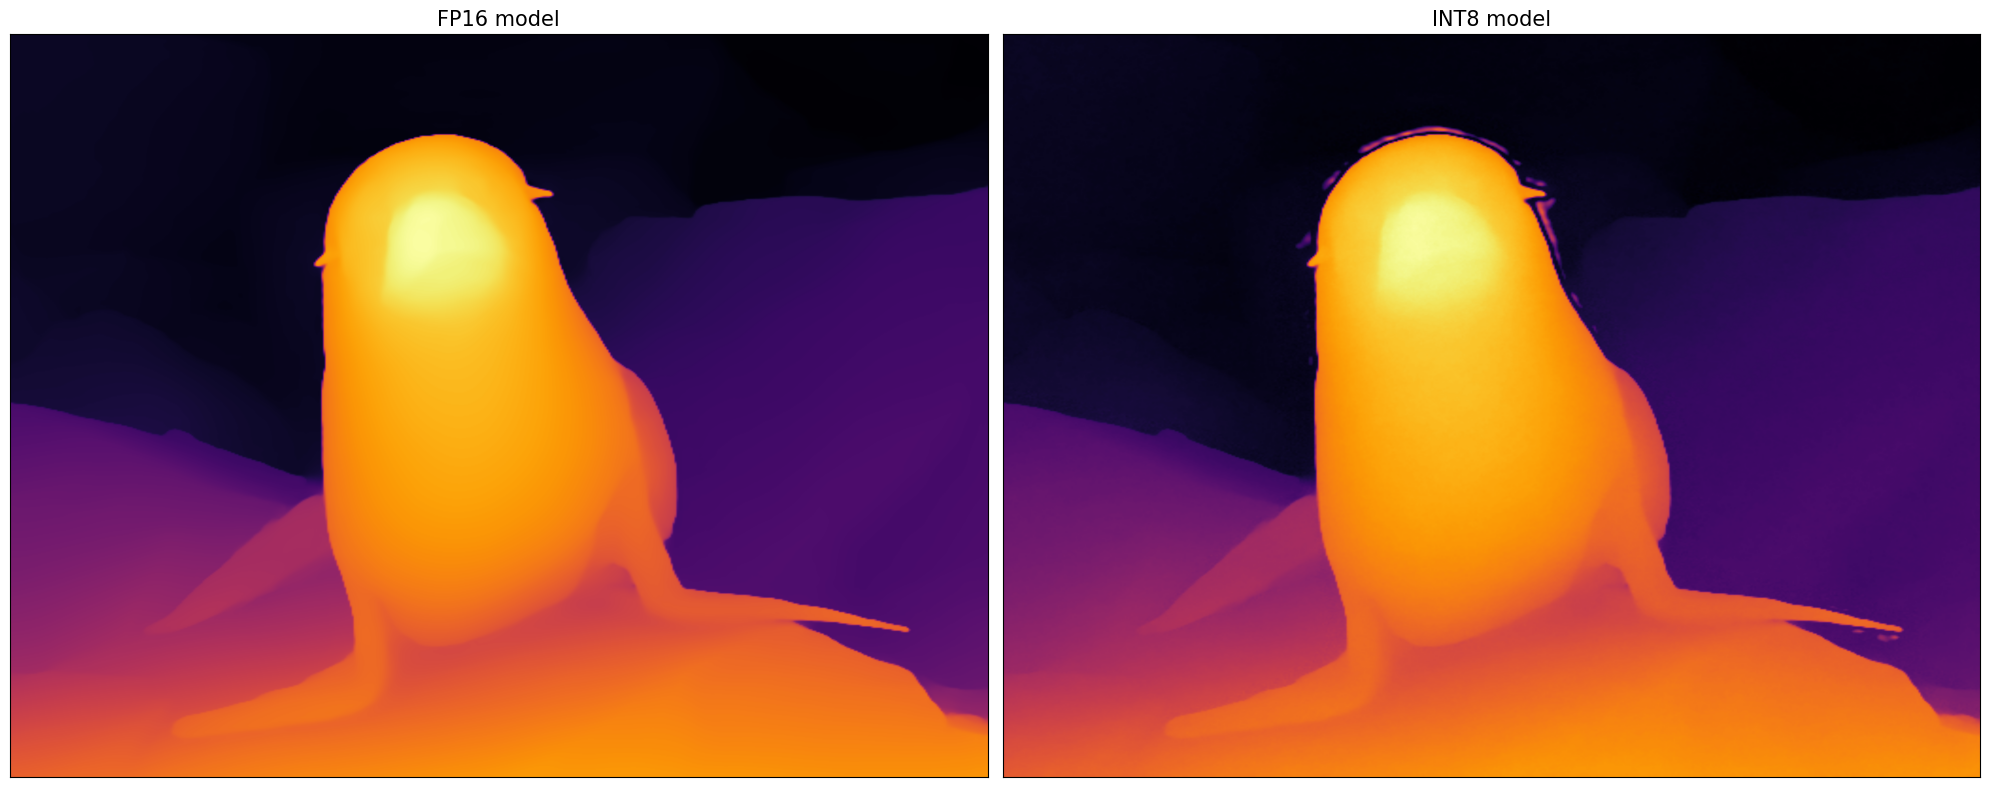

In [34]:
%%skip not $to_quantize.value

visualize_results(depth_color[:, :, ::-1], int8_depth_color[:, :, ::-1])

In [35]:
%%skip not $to_quantize.value

int8_result_video_path = output_directory / f"{Path(VIDEO_FILE).stem}_depth_anything_int8.mp4"
stacked_frame = process_video(int8_compiled_model, VIDEO_FILE, int8_result_video_path)
display_video(stacked_frame)

Processed 60 frames in 11.42 seconds. Total FPS (including video processing): 5.25.Inference FPS: 16.07 
Video saved to 'output/Coco Walking in Berkeley_depth_anything_int8.mp4'.
Showing video saved at
/home/labuser/work/notebook/openvino_notebooks/notebooks/depth-anything/Depth-Anything-V2/output/Coco Walking in Berkeley_depth_anything.mp4
If you cannot see the video in your browser, please click on the following link to download the video 


#### Compare model file size
[back to top ⬆️](#Table-of-contents:)

In [36]:
%%skip not $to_quantize.value

fp16_ir_model_size = OV_DEPTH_ANYTHING_PATH.with_suffix(".bin").stat().st_size / 2**20
quantized_model_size = OV_DEPTH_ANYTHING_INT8_PATH.with_suffix(".bin").stat().st_size / 2**20

print(f"FP16 model size: {fp16_ir_model_size:.2f} MB")
print(f"INT8 model size: {quantized_model_size:.2f} MB")
print(f"Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

FP16 model size: 47.11 MB
INT8 model size: 24.41 MB
Model compression rate: 1.930


### Compare inference time of the FP16 and INT8 models
[back to top ⬆️](#Table-of-contents:)

To measure the inference performance of OpenVINO FP16 and INT8 models, use [Benchmark Tool](https://docs.openvino.ai/2024/learn-openvino/openvino-samples/benchmark-tool.html).

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications.

In [37]:
import re


def get_fps(benchmark_output: str):
    parsed_output = [line for line in benchmark_output if "Throughput:" in line]
    fps = re.findall(r"\d+\.\d+", parsed_output[0])[0]
    return fps


if OV_DEPTH_ANYTHING_INT8_PATH.exists():
    benchmark_output = !benchmark_app -m $OV_DEPTH_ANYTHING_PATH -d $device.value -api async
    original_fps = get_fps(benchmark_output)
    print(f"FP16 Throughput: {original_fps} FPS")

    benchmark_output = !benchmark_app -m $OV_DEPTH_ANYTHING_INT8_PATH -d $device.value -api async
    optimized_fps = get_fps(benchmark_output)
    print(f"INT8 Throughput: {optimized_fps} FPS")
    print(f"Speed-up: {float(optimized_fps) / float(original_fps):.2f}")

FP16 Throughput: 13.48 FPS
INT8 Throughput: 14.64 FPS
Speed-up: 1.09


## Interactive demo
[back to top ⬆️](#Table-of-contents:)

You can apply model on own images. You can move the slider on the resulting image to switch between the original image and the depth map view.

Please select below whether you would like to use the quantized model to launch the interactive demo.

In [38]:
import ipywidgets as widgets

quantized_model_present = OV_DEPTH_ANYTHING_INT8_PATH.exists()

use_quantized_model = widgets.Checkbox(
    value=True if quantized_model_present else False,
    description="Use quantized model",
    disabled=False,
)

use_quantized_model

Checkbox(value=True, description='Use quantized model')

In [ ]:
import numpy as np
import cv2
import tempfile

if use_quantized_model.value:
    compiled_model = core.compile_model(OV_DEPTH_ANYTHING_INT8_PATH, device.value)


def predict_depth(model, image):
    return model(image)[0]


def on_submit(image):
    original_image = image.copy()

    h, w = image.shape[:2]

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0
    image = transform({"image": image})["image"]
    image = np.expand_dims(image, 0)

    depth = predict_depth(compiled_model, image)
    depth = cv2.resize(depth[0], (w, h), interpolation=cv2.INTER_LINEAR)

    raw_depth = Image.fromarray(depth.astype("uint16"))
    tmp = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
    raw_depth.save(tmp.name)

    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    depth = depth.astype(np.uint8)
    colored_depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)[:, :, ::-1]

    return [(original_image, colored_depth), tmp.name]

In [ ]:
# Go back to the depth-anything notebook directory
%cd ..

if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/depth-anything/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

demo = make_demo(fn=on_submit, examples_dir="Depth-Anything-V2/assets/examples")

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/